In [1]:
import os
import cv2
import numpy as np
import random, tqdm
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp
import albumentations as album

In [2]:
DATA_DIR = '/home/sputnik-research/datasets/balraj98/deepglobe-land-cover-classification-dataset/versions/2/'

In [3]:
metadata_df = pd.read_csv(os.path.join(DATA_DIR, 'metadata.csv'))
metadata_df.groupby('split').nunique().reset_index()

,split,image_id,sat_image_path,mask_path
0,test,172,172,0
1,train,803,803,803
2,valid,171,171,0


In [4]:
metadata_df = metadata_df[metadata_df['split']=='train']
metadata_df = metadata_df[['image_id', 'sat_image_path', 'mask_path']]
metadata_df['sat_image_path'] = metadata_df['sat_image_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
metadata_df['mask_path'] = metadata_df['mask_path'].apply(lambda img_pth: os.path.join(DATA_DIR, img_pth))
# Shuffle DataFrame
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)

# Perform 90/10 split for train / val
valid_df = metadata_df.sample(frac=0.1, random_state=42)
train_df = metadata_df.drop(valid_df.index)
len(train_df), len(valid_df)


(723, 80)

In [5]:
class_dict = pd.read_csv(os.path.join(DATA_DIR, 'class_dict.csv'))
# Get class names
class_names = class_dict['name'].tolist()
# Get class RGB values
class_rgb_values = class_dict[['r','g','b']].values.tolist()

select_classes = ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']

# Get RGB values of required classes
select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Selected classes and their corresponding RGB values in labels:')
print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)


Selected classes and their corresponding RGB values in labels:
Class Names:  ['urban_land', 'agriculture_land', 'rangeland', 'forest_land', 'water', 'barren_land', 'unknown']
Class RGB values:  [[0, 255, 255], [255, 255, 0], [255, 0, 255], [0, 255, 0], [0, 0, 255], [255, 255, 255], [0, 0, 0]]


In [6]:
# helper function for data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]);
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map

# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image

    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x


In [7]:
class LandCoverDataset(torch.utils.data.Dataset):

    """DeepGlobe Land Cover Classification Challenge Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        df (str): DataFrame containing images / labels paths
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    def __init__(
            self, 
            df,
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.image_paths = df['sat_image_path'].tolist()
        self.mask_paths = df['mask_path'].tolist()
        
        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read images and masks
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)


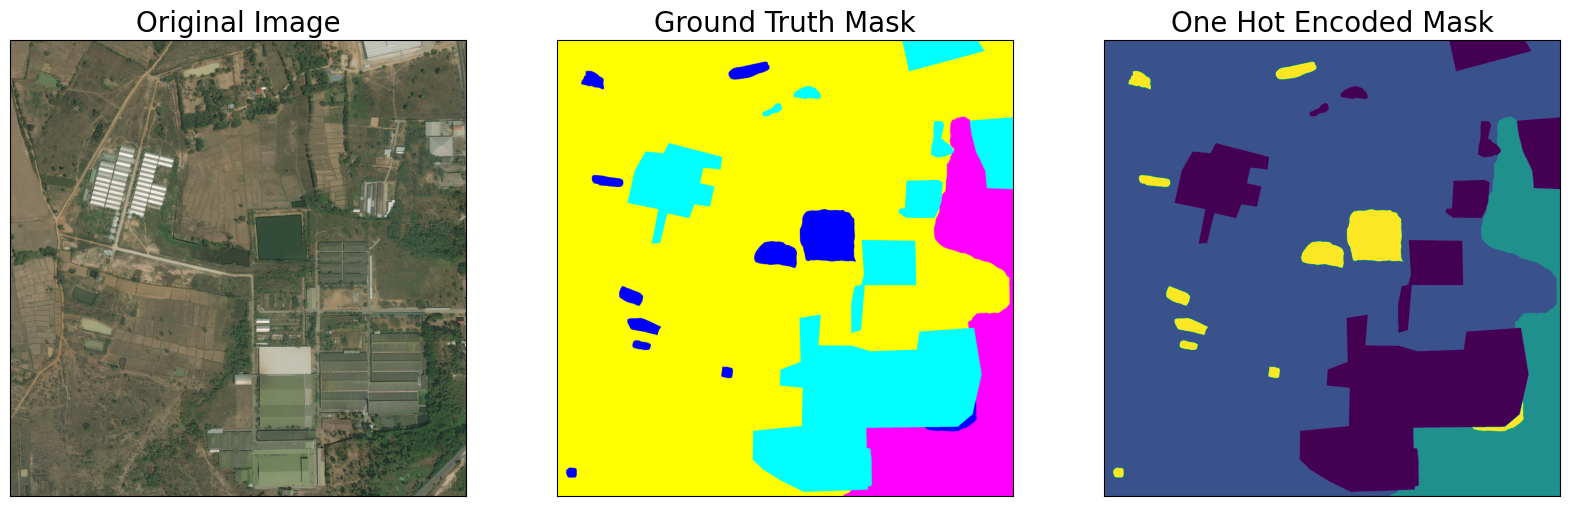

In [8]:
dataset = LandCoverDataset(train_df, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


In [9]:
mask.shape, reverse_one_hot(mask).shape

((2448, 2448, 7), (2448, 2448))

In [10]:
IMG_SIZE = 1024

In [11]:
# Satellite image augmentation pipeline
satellite_transform = album.Compose([
    # --- Geometric Augmentations ---
    # album.RandomResizedCrop(height=256, width=256, scale=(0.8, 1.0), ratio=(0.75, 1.33), p=1.0),
    album.RandomCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),
    album.HorizontalFlip(p=0.5),
    album.VerticalFlip(p=0.5),
    album.RandomRotate90(p=0.2),

    # --- Color and Brightness Adjustments ---
    album.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.2),
    album.HueSaturationValue(hue_shift_limit=10, sat_shift_limit=15, val_shift_limit=10, p=0.2),
    album.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.2),

    # --- Blur / Noise ---
    album.OneOf([
        album.GaussianBlur(blur_limit=(3, 5), p=0.2),
        album.MedianBlur(blur_limit=3, p=0.2),
    ], p=0.3),

    # --- Other useful augmentations ---
    album.RandomGamma(gamma_limit=(80, 120), p=0.3),
    album.CLAHE(clip_limit=2.0, p=0.2),
])


In [12]:
def get_training_augmentation():
    return satellite_transform

def get_validation_augmentation():
    validation_transform = [
        album.CenterCrop(height=IMG_SIZE, width=IMG_SIZE, always_apply=True),
    ]
    return album.Compose(validation_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform
    Args:
        preprocessing_fn (callable): data normalization function
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))

    return album.Compose(_transform)


In [13]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = select_classes
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
pretrained_checkpoint_path = 'best_model_kaggle.pth'

# create segmentation model with pretrained encoder
# model = smp.DeepLabV3Plus(
#     encoder_name=ENCODER,
#     encoder_weights=ENCODER_WEIGHTS,
#     classes=len(CLASSES),
#     activation=ACTIVATION,
# )
model = torch.load(pretrained_checkpoint_path, map_location='cpu')

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)


In [14]:
BATCH_SIZE = 12

In [15]:
# model_kaggle = torch.load(pretrained_checkpoint_path, map_location='cpu')

In [16]:
# Get train and val dataset instances
train_dataset = LandCoverDataset(
    train_df,
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

valid_dataset = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=2)

In [17]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cuda')

In [18]:
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.00008),
])


In [19]:
def train_one_epoch(model, loader, optimizer, loss_fn, device, mode="multiclass"):
    model.train()
    total_loss, total_iou, n = 0.0, 0.0, 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        logits = model(images)
        loss = loss_fn(logits, masks)
        loss.backward()
        optimizer.step()

        # with torch.no_grad():
        #     iou = compute_iou(logits, masks, mode=mode)
        bs = images.size(0)
        total_loss += loss.item() * bs
        # total_iou  += float(iou) * bs
        n += bs
    return {"loss": total_loss / n}  # , "iou_score": total_iou / n}

@torch.no_grad()
def valid_one_epoch(model, loader, loss_fn, device, mode="binary"):
    model.eval()
    total_loss, total_iou, n = 0.0, 0.0, 0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        logits = model(images)
        loss = loss_fn(logits, masks)
        # iou = compute_iou(logits, masks, mode=mode)
        bs = images.size(0)
        total_loss += loss.item() * bs
        # total_iou  += float(iou) * bs
        n += bs
    return {"loss": total_loss / n} #, "iou_score": total_iou / n}


In [20]:
for images, masks in train_loader:
    print(images.shape, masks.shape)
    break

torch.Size([12, 3, 1024, 1024]) torch.Size([12, 7, 1024, 1024])


In [21]:
model.to(DEVICE);

In [22]:
SAVE_DIR = 'checkpoints'
if not os.path.exists(SAVE_DIR):
    os.mkdir(SAVE_DIR)

In [ ]:
for epoch in range(40):
    print(f"\nEpoch {epoch}")
    train_logs = train_one_epoch(model, train_loader, optimizer, loss, DEVICE, mode="multiclass")
    valid_logs = valid_one_epoch(model, valid_loader, loss, DEVICE, mode="multiclass")
    print(f"train: {train_logs} | valid: {valid_logs}")
    # Save full checkpoint
    checkpoint_path = os.path.join(SAVE_DIR, f'model_epoch_{epoch+1}.pth')
    torch.save({
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_logs["loss"],
        'valid_loss': valid_logs["loss"],
    }, checkpoint_path)

    print(f"✅ Saved to Google Drive: {checkpoint_path}")



Epoch 0


In [ ]:
# create test dataloader to be used with DeepLabV3+ model (with preprocessing operation: to_tensor(...))
test_dataset = LandCoverDataset(
    valid_df, 
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing augmentations & transformations)
test_dataset_vis = LandCoverDataset(
    valid_df,
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)


Test results

In [ ]:
best_model = model
best_model.to(DEVICE);

In [ ]:
sample_preds_folder = 'sample_predictions/'
if not os.path.exists(sample_preds_folder):
    os.makedirs(sample_preds_folder)


In [ ]:
for idx in range(len(test_dataset)):

    image, gt_mask = test_dataset[idx]
    image_vis = test_dataset_vis[idx][0].astype('uint8')
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to foreground
    pred_urban_land_heatmap = pred_mask[:,:,select_classes.index('urban_land')]
    pred_mask = colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values)
    # Convert gt_mask from `CHW` format to `HWC` format
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values)
    cv2.imwrite(os.path.join(sample_preds_folder, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    visualize(
        original_image = image_vis,
        ground_truth_mask = gt_mask,
        predicted_mask = pred_mask,
        pred_urban_land_heatmap = pred_urban_land_heatmap
    )
